In [1]:
import nengo
import nengo_spa as spa
import numpy as np
from random import shuffle
import random
import sys, os
import math
from IPython import display

# Import our classes
sys.path.append('..')
import experiments as xps
from experiments import create_xp
from fixedGWModel import Model, create_vocab

# Select Nengo simulator according to whether we want to use ocl or not
use_ocl = True
if use_ocl:
    import nengo_ocl
    simulator_cls = nengo_ocl.Simulator
else:
    simulator_cls = nengo.Simulator
    


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from cycler import cycler
%matplotlib inline

# color-blind accessibility
default_cycler = cycler('color', ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
plt.rc('axes', prop_cycle=(default_cycler))


# Model variables

In [2]:
D = int(96)  # the dimensionality of the vectors
PROC_FDBCK = .8
PROC_FDBCK_SYN = .005
PREV_FDBCK_SYN = .01
GW_FDBCK = 1
GW_THR = .5
GW_SCALE = 20 # scale the input of GW for saturation and catching very short visual stimuli
BG_THR = .1
BG_BIAS = .5
STIM_DURATION = .029
FIX_DURATION = .5
N_NEURONS_SCALE = 1
N_NEURONS_SCALE_COMBINED = 1
S_CROSSTALK = .5
S_EVIDENCE = 15
N_SAMPLES = 1000
T_SENSO = 0
INTEGRATOR_RESET = False

N_BLOCKS_PER_OPERATION = 1 # default: 10
N_TRIALS_PER_DIGIT = 1 # default: 5
N_DIFFERENT_DIGITS = 1 # default: 4
N_DIFFERENT_OPERATIONS = 3 # default: 3

# Number of neurons
N_NEURONS_PER_DIM = { # initialize to default values then scale
    module: int(number*N_NEURONS_SCALE) for module,number in { 
    'AM': 50,
    'Ensemble': 50,
    'State': 50,
    'BG': 100,
    'thal_1': 50,
    'thal_2': 40,
    'Scalar': 50, # NB: this is for the whole module (one dim)
}.items()}
N_NEURONS_PER_DIM['combined'] = int(50*N_NEURONS_SCALE_COMBINED)

number_of_total_trials = N_BLOCKS_PER_OPERATION * N_TRIALS_PER_DIGIT * N_DIFFERENT_DIGITS * N_DIFFERENT_OPERATIONS
number_of_non_learning_trials = number_of_total_trials
number_of_learning_trials = max(0,number_of_total_trials - number_of_non_learning_trials)
seed = np.random.randint(99999)
seed = 10
print(seed)

vocab = create_vocab(D, seed)
xp = create_xp(N_BLOCKS_PER_OPERATION, N_TRIALS_PER_DIGIT, N_DIFFERENT_DIGITS, N_DIFFERENT_OPERATIONS, STIM_DURATION, FIX_DURATION, seed)
#     xp = xps.TestMasking(.2, number_of_learning_trials, trials) # SOA can be 16, 33 or 83ms

T = number_of_total_trials * xp.trial_length - .00001# simulations run a bit too long

model = Model(
    vocab, 
    xp, 
    S_CROSSTALK, 
    S_EVIDENCE, 
    N_SAMPLES, 
    INTEGRATOR_RESET, 
    T_SENSO, 
    PROC_FDBCK, 
    PROC_FDBCK_SYN, 
    PREV_FDBCK_SYN, 
    GW_FDBCK, 
    GW_THR, 
    GW_SCALE, 
    BG_THR, 
    BG_BIAS, 
    N_NEURONS_PER_DIM, 
    seed=seed, 
    plot=True)

sim = model.run(simulator_cls)

10


/home/ubuntu/anaconda3/envs/CTN/lib/python3.7/site-packages/nengo_spa/vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=96, M=19, similarity=0.10)
  len(self._key2idx), best_sim))


No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

# Plot results

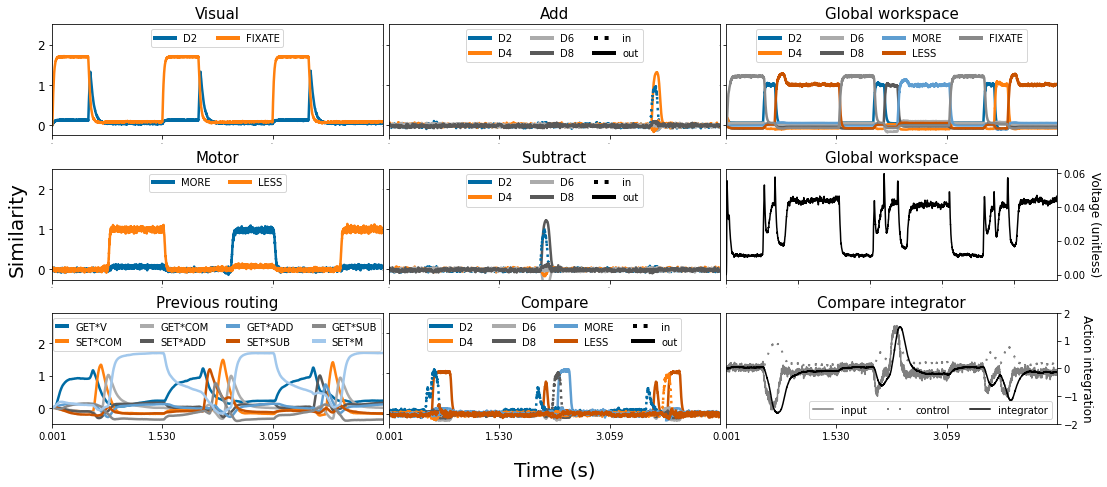

In [63]:
if True:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=False, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1, secondary_data=None):
        
        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        if title=='Previous routing':
            ymin, ymax = -.5, 2.95
        else:
            ymin, ymax = -.25, 2.5
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(False)
        handles = plt.plot(t_range, spa.similarity(data, vectors), linewidth=2.5)
        leg = plt.legend(keys)
        if secondary_data is not None:
            plt.gca().set_prop_cycle(default_cycler)
            plt.plot(t_range, spa.similarity(secondary_data, vectors), linestyle='dotted', linewidth=2.5)
            handles += plt.plot(t_range[0], linestyle='dotted', color='black', label='in')
            handles += plt.plot(t_range[0], linestyle='solid', color='black', label='out')
            keys += ['in', 'out']
        plt.title(title, size=15)
        if subplot_i==8:
            plt.xlabel("Time (s)", size=20, labelpad=20)
#         plt.ylabel("Similarity", size=15)
        plt.xlim(left=t_range[0], right=t_range[-1])
        leg = plt.legend(handles, keys, loc='upper center', 
                         ncol=5 if title=="Workspace source" else 3 if title=='Add' or title=='Subtract' else 4,
                        handlelength=1 if title=='Previous routing' else 2)
#         leg = plt.legend([k.replace('*CONTENT','')+': '+str(round(mean_activation[sort_idx][i],2)) for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center', ncol=3)
#         leg = plt.legend([k+': '+str(round(mean_activation[sort_idx][i],2)) for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center', ncol=3)
        
        for line in leg.get_lines():
            line.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()
            
        plt.yticks(range(3), range(3), fontsize=12 if (subplot_i-1)%3==0 else 0)
        plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length), fontsize=10 if subplot_i in [7,8,9] else 0)


        return subplot_i + 1

    

    subplot_nrows=4
    subplot_ncols=3
    plt.figure(figsize=(6*subplot_ncols,2.5*subplot_nrows))
    
    def trial_t(trial_number):
        return trial_number*xp.trial_length
    
    focus_start = 0 # first trial to plot
    n_focus = 3 # how many trials to plot
    start = trial_t(focus_start)
    end = trial_t(focus_start+n_focus)
    skip = 1
    trange = sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


#     subplot_i=plot_similarities(trange, sim.data[model.probes['G']][selected_idx][::skip], model.vocab, keys=['SIMPLE','CHAINED_SUB','CHAINED_ADD'], title='Task', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[model.probes['processors']['V']['out']][selected_idx][::skip], model.vocab, keys=['D2','FIXATE'], title='Visual', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[model.probes['processors']['ADD']['out']][selected_idx][::skip], model.vocab, keys=['D2','D4','D6','D8'], title='Add', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols,
                         secondary_data=sim.data[model.probes['processors']['ADD']['in']][selected_idx][::skip])
    subplot_i=plot_similarities(trange, sim.data[model.probes['GW']['out']][selected_idx][::skip], model.vocab, keys=['D2','D4','D6','D8','MORE','LESS','FIXATE'], title='Global workspace', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[model.probes['processors']['M']['out']][selected_idx][::skip], model.vocab, keys=['MORE','LESS'], title='Motor', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[model.probes['processors']['SUB']['out']][selected_idx][::skip], model.vocab, keys=['D2','D4','D6','D8'], title='Subtract', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols,
                         secondary_data=sim.data[model.probes['processors']['SUB']['in']][selected_idx][::skip])
    
#     subplot_i=plot_similarities(trange, sim.data[model.probes['processors']['COM']['clean input']][selected_idx][::skip], model.vocab, keys=['D2','D4','D6','D8'], title='Clean COM input', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
#     subplot_i=plot_similarities(trange, sim.data[model.probes['GW source']['out']][selected_idx][::skip], model.vocab, keys=['V','COM','ADD','SUB'], title='GW source', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    
    plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.title("Global workspace", size=15)
    voltage_recordings = np.array([sim.data[data] for data in model.probes['GW']['voltages']]).mean(axis=(0,2))
    plt.plot(trange, voltage_recordings[selected_idx][::skip], color='black')
    plt.ylabel('Voltage (unitless)', labelpad=15, size=12).set_rotation(-90)
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.xlim(left=trange[0], right=trange[-1])
    plt.xticks(range(5), range(5), fontsize=0)
    subplot_i+=1
    
    subplot_i=plot_similarities(trange, sim.data[model.probes['PREV']][selected_idx][::skip], model.vocab, keys=['GET*V','SET*COM','GET*COM','SET*ADD','GET*ADD','SET*SUB','GET*SUB','SET*M'], title='Previous routing', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[model.probes['processors']['COM']['out']][selected_idx][::skip], model.vocab, keys=['D2','D4','D6','D8','MORE','LESS'], title='Compare', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols,
                         secondary_data=sim.data[model.probes['processors']['COM']['in']][selected_idx][::skip])

#    
    
    plt.subplots_adjust(hspace=0.3, wspace=0.02)

#     plt.text(-1.1,-1.5,'Time (s)', fontdict={"fontsize":20})
    plt.text(-5.3, 3.5,'Similarity', fontdict={"fontsize":20}, rotation=90)
#     plt.show()
    
    plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.title('Compare integrator', size=15)
#     plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.plot(trange, sim.data[model.probes['compared']][selected_idx], color='gray', linewidth=1.5, linestyle='solid', label='input')
    plt.plot(trange, sim.data[model.probes['integrator']][selected_idx][:,1], color='gray', linewidth=2, linestyle=(0, (1, 5)), label='control')
    plt.plot(trange, sim.data[model.probes['integrator']][selected_idx][:,0], color='black', linewidth=1.5, label='integrator')
    plt.xlim(left=trange[0], right=trange[-1])
    plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length), fontsize=10)

#     plt.yticks([-.5,.5], ['-','+'])
#     plt.ylim(-.2,2.2)
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.ylim(-2,2)
    plt.ylabel("Action integration", labelpad=15, size=12).set_rotation(-90)
    plt.legend(ncol=3)#, handlelength=3)
    subplot_i+=1
    
#     plt.savefig('cogsci_trial.svg')
    plt.show()
    
#     plt.plot(sim.trange()[selected_idx], sim.data[model.probes['BTN']][selected_idx])
        
#     for p in model.senders:
#         print(p.label)
#         plt.plot(trange, sim.data[model.probes['processors'][p.label]['sent']][selected_idx])
#         plt.title('sent '+p.label)
#         plt.show()
        
#     for p in model.receivers:
#         print(p.label)
#         plt.plot(trange, sim.data[model.probes['processors'][p.label]['received']][selected_idx])
#         plt.title('received '+p.label)
#         plt.show()
    
# #     plt.plot(trange, sim.data[model.probes['PREV_reset_step']][selected_idx])
# #     plt.show()

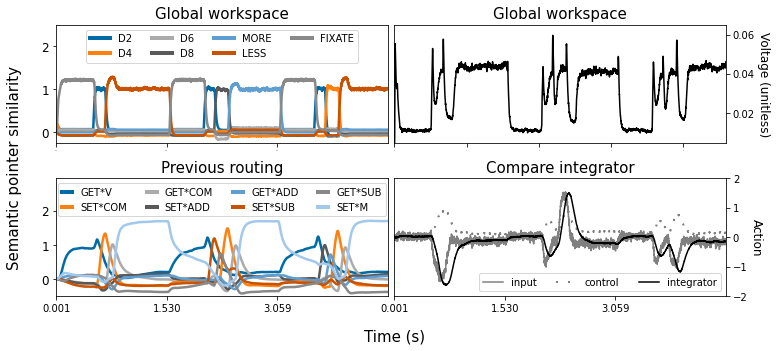

In [94]:
if True:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=False, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1, secondary_data=None):
        
        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        if title=='Previous routing':
            ymin, ymax = -.5, 2.95
        else:
            ymin, ymax = -.25, 2.5
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(False)
        handles = plt.plot(t_range, spa.similarity(data, vectors), linewidth=2.5)
        leg = plt.legend(keys)
        if secondary_data is not None:
            plt.gca().set_prop_cycle(default_cycler)
            plt.plot(t_range, spa.similarity(secondary_data, vectors), linestyle='dotted', linewidth=2.5)
            handles += plt.plot(t_range[0], linestyle='dotted', color='black', label='in')
            handles += plt.plot(t_range[0], linestyle='solid', color='black', label='out')
            keys += ['in', 'out']
        plt.title(title, size=15)
        if subplot_i==8:
            plt.xlabel("Time (s)", size=20, labelpad=20)
#         plt.ylabel("Similarity", size=15)
        plt.xlim(left=t_range[0], right=t_range[-1])
        leg = plt.legend(handles, keys, loc='upper center', 
                         ncol=5 if title=="Workspace source" else 3 if title=='Add' or title=='Subtract' else 4,
                        handlelength=1 if title=='Previous routing' else 2)
#         leg = plt.legend([k.replace('*CONTENT','')+': '+str(round(mean_activation[sort_idx][i],2)) for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center', ncol=3)
#         leg = plt.legend([k+': '+str(round(mean_activation[sort_idx][i],2)) for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center', ncol=3)
        
        for line in leg.get_lines():
            line.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()
            
        plt.yticks(range(3), range(3), fontsize=12 if (subplot_i-1)%2==0 else 0)
        plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length), fontsize=10 if subplot_i in [3,4] else 0)


        return subplot_i + 1

    

    subplot_nrows=2
    subplot_ncols=2
    plt.figure(figsize=(6*subplot_ncols,2.5*subplot_nrows))
    
    def trial_t(trial_number):
        return trial_number*xp.trial_length
    
    focus_start = 0 # first trial to plot
    n_focus = 3 # how many trials to plot
    start = trial_t(focus_start)
    end = trial_t(focus_start+n_focus)
    skip = 1
    trange = sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


#     subplot_i=plot_similarities(trange, sim.data[model.probes['G']][selected_idx][::skip], model.vocab, keys=['SIMPLE','CHAINED_SUB','CHAINED_ADD'], title='Task', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[model.probes['GW']['out']][selected_idx][::skip], model.vocab, keys=['D2','D4','D6','D8','MORE','LESS','FIXATE'], title='Global workspace', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    
#     subplot_i=plot_similarities(trange, sim.data[model.probes['processors']['COM']['clean input']][selected_idx][::skip], model.vocab, keys=['D2','D4','D6','D8'], title='Clean COM input', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
#     subplot_i=plot_similarities(trange, sim.data[model.probes['GW source']['out']][selected_idx][::skip], model.vocab, keys=['V','COM','ADD','SUB'], title='GW source', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    

    plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.title("Global workspace", size=15)
    voltage_recordings = np.array([sim.data[data] for data in model.probes['GW']['voltages']]).mean(axis=(0,2))
    plt.plot(trange, voltage_recordings[selected_idx][::skip], color='black')
    plt.ylabel('Voltage (unitless)', labelpad=15, size=12).set_rotation(-90)
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.xlim(left=trange[0], right=trange[-1])
    plt.xticks(range(5), range(5), fontsize=0)
    plt.ylim(.005, .065)
    subplot_i+=1
    
    subplot_i=plot_similarities(trange, sim.data[model.probes['PREV']][selected_idx][::skip], model.vocab, keys=['GET*V','SET*COM','GET*COM','SET*ADD','GET*ADD','SET*SUB','GET*SUB','SET*M'], title='Previous routing', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    
    plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.title('Compare integrator', size=15)
#     plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.plot(trange, sim.data[model.probes['compared']][selected_idx], color='gray', linewidth=1.5, linestyle='solid', label='input')
    plt.plot(trange, sim.data[model.probes['integrator']][selected_idx][:,1], color='gray', linewidth=2, linestyle=(0, (1, 5)), label='control')
    plt.plot(trange, sim.data[model.probes['integrator']][selected_idx][:,0], color='black', linewidth=1.5, label='integrator')
    plt.xlim(left=trange[0], right=trange[-1])
    plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length), fontsize=10)
#     plt.yticks([-.5,.5], ['-','+'])
#     plt.ylim(-.2,2.2)
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.ylim(-2,2)
    plt.ylabel("Action", labelpad=15, size=12).set_rotation(-90)
    plt.legend(ncol=3)#, handlelength=3)
    subplot_i+=1
    
    plt.subplots_adjust(hspace=0.3, wspace=0.02)

    plt.text(0,-3.5,'Time (s)', fontdict={"fontsize":15}, ha='center')
    plt.text(-5.25, -1,'Semantic pointer similarity', fontdict={"fontsize":15}, rotation=90, ha='center')
#     plt.show()
    
    plt.savefig('cogsci_trial.svg')
    plt.show()
    
#     plt.plot(sim.trange()[selected_idx], sim.data[model.probes['BTN']][selected_idx])
        
#     for p in model.senders:
#         print(p.label)
#         plt.plot(trange, sim.data[model.probes['processors'][p.label]['sent']][selected_idx])
#         plt.title('sent '+p.label)
#         plt.show()
        
#     for p in model.receivers:
#         print(p.label)
#         plt.plot(trange, sim.data[model.probes['processors'][p.label]['received']][selected_idx])
#         plt.title('received '+p.label)
#         plt.show()
    
# #     plt.plot(trange, sim.data[model.probes['PREV_reset_step']][selected_idx])
# #     plt.show()

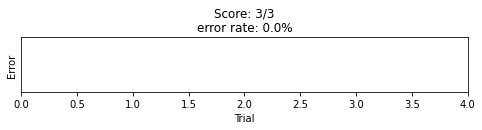

In [7]:
digit_key_to_int = {'D2':2, 'D4':4, 'D6':6, 'D8':8}
digit_key_to_idx = {k:i for i,k in enumerate(digit_key_to_int.keys())}
operations_key_to_idx = {k:i for i,k in enumerate(['SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB'])}

n_per_condition = N_BLOCKS_PER_OPERATION * N_TRIALS_PER_DIGIT

RTs = np.zeros((N_DIFFERENT_OPERATIONS, N_DIFFERENT_DIGITS, n_per_condition)) 
performance = np.zeros((N_DIFFERENT_OPERATIONS, N_DIFFERENT_DIGITS, n_per_condition)) # 0:no answer / 1:wrong answer / 2:correct answer
xp_errors = []
model_actions = []
expected_actions = []

indices = np.zeros((N_DIFFERENT_OPERATIONS, N_DIFFERENT_DIGITS), dtype=int) 


def get_expected_action(trial):
    N = digit_key_to_int[trial.stimulus] 
    if trial.operation == 'CHAINED_ADD':
        N += 2
    elif trial.operation == 'CHAINED_SUB':
        N -= 2
    if N > 8:
        N = 2
    elif N < 2:
        N = 8
    expected_action = 1 + int(N > 5)
    return expected_action

t = 0
while t<T-.01:
    t += xp.trial_length
    trial = model.experiment(t)[0]
    expected_action = get_expected_action(trial)
    expected_actions.append(expected_action)
    t_window = (np.where(np.logical_and(sim.trange() < t, sim.trange() > t-model.experiment.trial_length))[0],)
    
    # get model's action
    model_behaviour = sim.data[model.probes['BTN']][t_window]
    if np.count_nonzero(model_behaviour) > 1:
        raise ValueError("more than one action")
    
    
    cond_idx = (operations_key_to_idx[trial.operation], digit_key_to_idx[trial.stimulus])
    trial_idx = indices[cond_idx]
    
    model_action = model_behaviour.sum()
    model_actions.append(int(model_action))
    if model_action == 0:
        trial_RT = 0
        trial_performance = 0
    else:
        action_t_idx = np.nonzero(model_behaviour[:,0])
        trial_RT = sim.trange()[t_window][action_t_idx][0] - (t-model.experiment.trial_length) - model.experiment.t_start
        trial_performance = int(model_action==expected_action) + 1
    
    xp_errors += [trial_performance!=2]
    
    performance[cond_idx+(trial_idx,)] = trial_performance
    RTs[cond_idx+(trial_idx,)] = trial_RT
    
    indices[cond_idx] += 1 # increment index of this condition
    


xp_errors = np.array(xp_errors, dtype=bool)

plt.figure(figsize=(8,1))
plt.eventplot(np.where(xp_errors)[0]+1, color='black')
plt.yticks([])
plt.ylabel('Error')
plt.xlim(0,len(xp_errors)+1)
plt.title('Score: '+str(number_of_total_trials-xp_errors.sum())+'/'+str(number_of_total_trials)+"\n"+
         "error rate: "+str(round(100*xp_errors.sum()/number_of_total_trials,2))+"%")
plt.xlabel('Trial')
plt.show()




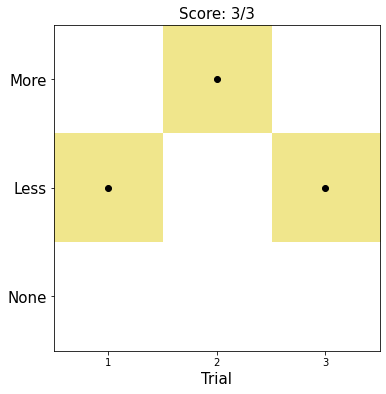

In [5]:
expected_actions_matrix = np.zeros((number_of_total_trials,3))
for i,a in enumerate(expected_actions):
    expected_actions_matrix[i,a] += 1

# cmap = ListedColormap(['white', 'cyan'])
cmap = ListedColormap(['white', 'khaki'])
    
# plt.figure(figsize=(16,6))
# plt.imshow(expected_actions_matrix.T, origin='lower', cmap=cmap)
# plt.xlabel("Trial", size=15)
# plt.yticks(range(3),['None','Less','More'], size=15)
# plt.xticks(range(number_of_total_trials), range(1,number_of_total_trials+1))

# plt.plot(model_actions,'o',color='black')
# plt.title('Score: '+str(number_of_total_trials-xp_errors.sum())+'/'+str(number_of_total_trials), size=15)
# plt.ylim(0.5,2.5)
# plt.show()

plt.figure(figsize=(16,6))
plt.imshow(expected_actions_matrix.T, origin='lower', cmap=cmap)
plt.xlabel("Trial", size=15)
plt.yticks(range(3),['None','Less','More'], size=15)
plt.xticks(range(number_of_total_trials), range(1,number_of_total_trials+1))

plt.plot(model_actions,'o',color='black')
plt.title('Score: '+str(number_of_total_trials-xp_errors.sum())+'/'+str(number_of_total_trials), size=15)
plt.show()

## Simple blocks plot

In [6]:
RTs_simple = np.copy(RTs[0,:,:]) * 1000
RTs_simple = [RTs_simple[i,:] for i in range(n_different_digits)]
print(RTs_simple)
for digit_RTs in RTs_simple:
#     print(digit_RTs.shape)
    digit_RTs = digit_RTs[digit_RTs != 0] # remove outliers (no answer)
#     print(digit_RTs.shape)
#     print('\n')

RTs_simple_median = np.array([np.median(digit_RTs) for digit_RTs in RTs_simple])
RTs_simple_std = np.array([digit_RTs.std() for digit_RTs in RTs_simple])
plt.errorbar([2,4,6,8][:n_different_digits], RTs_simple_median, yerr=RTs_simple_std, color='black', capsize=3, capthick=2, marker='.', markersize=12, markerfacecolor='white')
plt.ylabel('Median Reaction times (ms)')
plt.xlabel('Stimuli')
plt.xticks([2,4,6,8][:n_different_digits])
plt.show()

print(RTs_simple_median)




for unresponsive_as_error in [False,True]:

    if unresponsive_as_error:
        performance_simple = np.copy(performance[0,:,:])
        err_simple = np.sum(performance_simple != 2, axis=1) / n_per_condition * 100
        plt.title('Errors and absence of response')
        
    else:
        performance_simple = np.copy(performance[0,:,:])
        n_responsive = np.sum(performance_simple!=0) # count the number of responses
        err_simple = np.sum(performance_simple == 1, axis=1) / n_responsive * 100
        plt.title('Errors')

    plt.bar([2,4,6,8][:n_different_digits], err_simple, color='black')
    plt.ylabel('Error rates (%)')
    plt.xlabel('Stimuli')
    plt.xticks([2,4,6,8][:n_different_digits])
    plt.ylim(bottom=0)
    plt.show()
        

NameError: name 'n_different_digits' is not defined

# Attention

In [ ]:
plt.figure(figsize=(16,6))
i=0
for p in model.senders:
    plt.subplot(1,len(model.processors),i+1)
    plt.plot(trange, sim.data[model.probes['attention'][p.label+' attention']][selected_idx])
    plt.title(p.label)
    plt.ylim(-.2,2.2)
    i += 1
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
i=0
for p in model.receivers:
    plt.subplot(1,len(model.processors),i+1)
    plt.plot(trange, sim.data[model.probes['receive'][p.label+' receive']][selected_idx])
    plt.title(p.label)
    plt.ylim(-.2,2.2)
    i += 1
plt.show()

# Access

In [ ]:
plt.figure(figsize=(16,6))
for i in range(model.network.access_net.AS.bg.input.size_out):
    plt.subplot(1,model.network.access_net.AS.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx], sim.data[model.probes['AS_nets']['access']['in']][:,i][selected_idx])
    plt.title(model.network.access_net.labels[i])
    plt.ylim(-.5,1.5)

plt.show()

plt.figure(figsize=(16,6))
for i in range(model.network.access_net.AS.bg.input.size_out):
    plt.subplot(1,model.network.access_net.AS.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx], sim.data[model.probes['AS_nets']['access']['out']][:,i][selected_idx])
    plt.title(model.network.access_net.labels[i])
    plt.ylim(-.5,1.5)

plt.show()

# Routing

In [ ]:
plt.figure(figsize=(12,6*model.network.routing_net.AS.bg.input.size_out))
for i in range(model.network.routing_net.AS.bg.input.size_out):
    plt.subplot(model.network.routing_net.AS.bg.input.size_out, 1,i+1)
    plt.plot(sim.trange()[selected_idx], sim.data[model.probes['AS_nets']['routing']['in']][:,i][selected_idx])
    plt.title(model.network.routing_net.labels[i])
    plt.ylim(-.5,1.5)
plt.show()

plt.figure(figsize=(12,6*model.network.routing_net.AS.bg.input.size_out))
for i in range(model.network.routing_net.AS.bg.input.size_out):
    plt.subplot(model.network.routing_net.AS.bg.input.size_out, 1,i+1)
    plt.plot(sim.trange()[selected_idx], sim.data[model.probes['AS_nets']['routing']['out']][:,i][selected_idx])
    plt.title(model.network.routing_net.labels[i])
    plt.ylim(-.5,1.5)
plt.show()

# Avec - 10

In [ ]:
for j,p in enumerate(model.receivers):
    
    print(p.label)

    plt.figure(figsize=(16,6))
    for i in range(model.network.broadcast_nets[j].AS.bg.input.size_out):
        plt.subplot(1,model.network.broadcast_nets[j].AS.bg.input.size_out,i+1)
        plt.plot(sim.trange()[selected_idx], sim.data[model.probes['AS_nets']['broadcast '+p.label]['in']][:,i][selected_idx])
        plt.title(model.network.broadcast_nets[j].labels[i])
    plt.show()

    plt.figure(figsize=(16,6))
    for i in range(model.network.broadcast_nets[j].AS.bg.input.size_out):
        plt.subplot(1,model.network.broadcast_nets[j].AS.bg.input.size_out,i+1)
        plt.plot(sim.trange()[selected_idx], sim.data[model.probes['AS_nets']['broadcast '+p.label]['out']][:,i][selected_idx])
        plt.title(model.network.broadcast_nets[j].labels[i])
    plt.show()

# Sans - 10

In [ ]:
for j,p in enumerate(model.receivers):
    
    print(p.label)

    plt.figure(figsize=(16,6))
    for i in range(model.network.broadcast_nets[j].AS.bg.input.size_out):
        plt.subplot(1,model.network.broadcast_nets[j].AS.bg.input.size_out,i+1)
        plt.plot(sim.trange()[selected_idx], sim.data[model.probes['AS_nets']['broadcast '+p.label]['in']][:,i][selected_idx])
        plt.title(model.network.broadcast_nets[j].labels[i])
    plt.show()

    plt.figure(figsize=(16,6))
    for i in range(model.network.broadcast_nets[j].AS.bg.input.size_out):
        plt.subplot(1,model.network.broadcast_nets[j].AS.bg.input.size_out,i+1)
        plt.plot(sim.trange()[selected_idx], sim.data[model.probes['AS_nets']['broadcast '+p.label]['out']][:,i][selected_idx])
        plt.title(model.network.broadcast_nets[j].labels[i])
    plt.show()

In [ ]:
print(nengo.Direct())